In [52]:
import sys
import os
import numpy as np
from numpy import random as rd
import numpy as np
import pandas as pd
import pandas as pd
from scipy import stats
import re
import subprocess
import json
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time,datetime
from collections import Counter
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import miner_py3_kk as miner
import imp
#import miner
from tqdm.notebook import tqdm, trange
#imp.reload(miner)
%matplotlib inline
plt.style.use('ggplot')
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# Path to the miner directory
input_path = os.getcwd()
print("Current working directory: " + input_path)
    
resultsDirectory='/Volumes/omics4tb2/SYGNAL/GBM-Serdar/MINER_Run_ST_11172021'
dataDirectory='/Volumes/omics4tb2/SYGNAL/GBM-Serdar/data/'
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

2021-11-17 19:19:42
Current working directory: /Users/sturkars/github/GbmMINER/src


## Load Expression Data

In [47]:
expressionData = pd.read_csv(dataDirectory + "/GbmMicroRNAMergedWithIDsZScored.csv", header=0,index_col=0,sep=",")
expressionData.shape

(9728, 548)

## Gene Expression Clustering

Performing Initial clustering..

Running cluster function...



0.00 percent complete
20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete


coexpression clustering completed in 1.24 minutes
Performing Revised clustering..

Completed coexpression clustering in 1.65 minutes
Number of genes clustered: 9051
Number of unique clusters: 641
Completed clustering module in 1.65 minutes


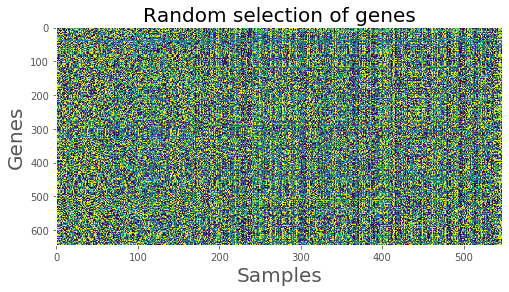

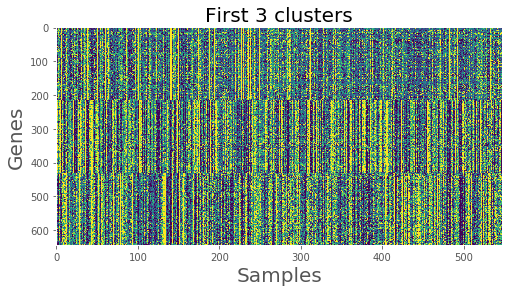

In [48]:
#import miner_py3 as miner
# minimum number of genes that form an acceptable coexpression cluster:
minNumberGenes = 6 #bulk RNAseq default=6;single cell RNAseq default=6

# minimum correlation coefficient for an acceptable regulator-cluster association 
minCorrelation = 0.2 #bulk RNAseq default=0.2;single cell RNAseq default=0.05

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
minNumberRegulonGenes = 5 #bulk RNAseq default=5;single cell RNAseq default=4

# choose database: if supplying your own database, use mechanistic_database = reference_mechanistic_database
mechanistic_database = dataDirectory + "tfbsdb_tf_to_genes.pkl" #default option
#mechanistic_database = reference_mechanistic_database #use if supplying your own database

# number of cores available for multiprocessing
import multiprocessing
numCores = multiprocessing.cpu_count()

# Network inference may take several minutes. 
# Prompts will print at 0, 20, 40, 60, 80, and 100% complete

t1 = time.time()
print("Performing Initial clustering..\n")
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes = minNumberGenes,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=17,overExpressionThreshold=80) 

print("Performing Revised clustering..\n")
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)

# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"output/coexpressionDictionary.json"))

t2 = time.time()
print("Completed coexpression clustering in {:.2f} minutes".format((t2-t1)/60.))

# retrieve first three clusters for visual inspection
first_clusters = np.hstack([revisedClusters[i] for i in np.arange(3).astype(str)])

# visualize background expression
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[np.random.choice(
    expressionData.index,len(first_clusters),
    replace=False),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",fontsize=20)
plt.xlabel("Samples",fontsize=20)
plt.title("Random selection of genes",fontsize=20)

# visualize first 10 clusters
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[first_clusters,:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",fontsize=20)
plt.xlabel("Samples",fontsize=20)
plt.title("First 3 clusters",fontsize=20)

# report coverage
print("Number of genes clustered: {:d}".format(len(set(np.hstack(initialClusters)))))
print("Number of unique clusters: {:d}".format(len(revisedClusters)))

t3 = time.time()
print("Completed clustering module in {:.2f} minutes".format((t3-t1)/60.))


#### Function to load regulons

## Mechanstic Inference

In [54]:
def loadRegulons(disease_relevant=True,disease_relevant_regulons_file= dataDirectory + "regulonDfGbmMicroRNASigCoxAndStatSig.csv"):
    
    # Load regulon Modules
    regulonModules = miner.read_json(os.path.join(resultsDirectory,"output/regulons.json"))
    print("Total number of regulons: " + str(len(regulonModules)))

    # load regulon data frame
    # All Regulons
    regulonDf = pd.read_csv(os.path.join(resultsDirectory, "output/regulonDf.csv"), header = 0)
    regulonDf = list(regulonDf['Regulon_ID'].drop_duplicates())
    regulonDf = [str(i) for i in regulonDf]
    

    # Disease relevant regulons
    regulonDfMicroGbmLatest = pd.read_csv(os.path.join(input_path,disease_relevant_regulons_file), header = 0)
    regulonDfMicroGbmLatest = list(regulonDfMicroGbmLatest['Regulon_ID'].drop_duplicates())
    regulonDfMicroGbmLatest = [str(i) for i in regulonDfMicroGbmLatest]
    regulonModulesFiltered = dict((k, regulonModules[k]) for k in regulonDfMicroGbmLatest if k in regulonModules)
    print("Filtered number of regulons: " + str(len(regulonModulesFiltered)))
    
    if disease_relevant == True:
        regulonModules = dict((k, regulonModules[k]) for k in regulonDfMicroGbmLatest if k in regulonModules)
        print("Returned %s filtered regulons" %(str(len(regulonModules))))
        return(regulonModules)
    
    else:
        regulonModules = dict((k, regulonModules[k]) for k in regulonDf if k in regulonModules)
        print("Returned %s Total regulons" %(str(len(regulonModules))))
        return(regulonModules)

In [55]:
#import miner_py3 as miner
t1 = time.time()

# get first principal component axes of clusters
input_path = os.getcwd()
revisedClusters = miner.read_json(os.path.join(resultsDirectory,"output/coexpressionDictionary.json"))

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
minNumberRegulonGenes = 5 #bulk RNAseq default=5;single cell RNAseq default=4
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
database_path = dataDirectory + "tfbsdb_tf_to_genes.pkl"

# minimum correlation coefficient for an acceptable regulator-cluster association 
minCorrelation = 0.2 #bulk RNAseq default=0.2;single cell RNAseq default=0.05

# number of cores available for multiprocessing
import multiprocessing
numCores = multiprocessing.cpu_count()

# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,correlationThreshold=minCorrelation,numCores=numCores,database=database_path)

# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(resultsDirectory,"output/mechanisticOutput.json"))

# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)

# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(resultsDirectory,"output/coregulationModules.json"))

# get final regulons by keeping genes that frequently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=minNumberRegulonGenes,freqThreshold = 0.333)

# reformat regulon dictionary for consistency with revisedClusters and coexpressionModules
regulonModules, regulonDf = miner.regulonDictionary(regulons)

# write regulonDf to csv using preferred gene name identifiers
regulonDf.to_csv(os.path.join(resultsDirectory,"output/regulonDf.csv"))

# write regulons to json file
miner.write_json(regulonModules,os.path.join(resultsDirectory,"output/regulons.json"))

# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)

# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"output/coexpressionModules.json"))

## If needed change the regulon modules loaded
# load regulons
regulonModules = loadRegulons(disease_relevant=False)
#regulonModules = miner.read_json("/Volumes/omics4tb2/SYGNAL/GBM-Serdar/MINER_MicroLowessRNATMM.08.24.2020/regulons.json")

# Get eigengenes for all modules
eigengenes = miner.getEigengenes(regulonModules,expressionData,regulon_dict=None,saveFolder=None)
eigenScale = np.percentile(expressionData,95)/np.percentile(eigengenes,95)
eigengenes = eigenScale*eigengenes
eigengenes.index = np.array(eigengenes.index).astype(str)
#write eigengenes to .csv
eigengenes.to_csv(os.path.join(resultsDirectory,"output/eigengenes.csv"))

t2 = time.time()
print("Completed mechanistic inference in {:.2f} minutes".format((t2-t1)/60.))
print("Inferred network with {:d} regulons, {:d} TF regulators, and {:d} co-regulated genes".format(len(regulonDf.Regulon_ID.unique()),len(regulonDf.Regulator.unique()),len(regulonDf.Gene.unique())))
print("Inferred network with 3764 regulons, 428 TF regulators, and 6781 co-regulated genes")

Running mechanistic inference


/Users/sturkars/github/GbmMINER/src/miner_py3_kk.py:1289: RuntimeWarning: invalid value encountered in greater_equal
  tfDict[tfDict_key] = tfs[np.where(np.abs(tfCorrelation)>=correlationThreshold)[0]]


Total number of regulons: 3787
Filtered number of regulons: 505
Returned 3787 Total regulons
Completed mechanistic inference in 5.17 minutes
Inferred network with 3787 regulons, 431 TF regulators, and 6676 co-regulated genes
Inferred network with 3764 regulons, 428 TF regulators, and 6781 co-regulated genes


## Network Mapping

In [56]:
#imp.reload(miner)
t1 = time.time()
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules

# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)

# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)

# for each clus|ter, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)

# for each cluster, give samples that do not show coherent cluster activity
dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")

# # for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"output/overExpressedMembersmiRNAAndTFRegulonsSig.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"output/underExpressedMembersmiRNAAndTFRegulonsSig.csv"))
dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"output/dysregulatedMembersmiRNAAndTFRegulonsSig.csv"))
coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"output/coherentMembersmiRNAAndTFRegulonsSig.csv"))

t2 = time.time()
print("Completed patient mapping in {:.2f} minutes".format((t2-t1)/60.))

biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
Completed Bicluster Membership dictionary for excluded. done!
Completed Bicluster Membership dictionary for included. done!
Completed patient mapping in 1.86 minutes


Text(0.5, 0, 'Samples')

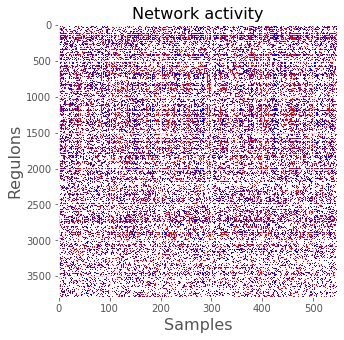

In [57]:
#visualize network activity across individual samples
plt.figure(figsize=(5,5))
network_activity_heatmap = overExpressedMembersMatrix-underExpressedMembersMatrix
plt.imshow(network_activity_heatmap,cmap="bwr",vmin=-1,vmax=1,aspect="auto")
plt.title("Network activity",fontsize=16)
plt.ylabel("Regulons",fontsize=16)
plt.xlabel("Samples",fontsize=16)

## Infer Patient Subtypes

In [58]:
import miner_py3 as miner
# Infer transcriptional states
minClusterSize = int(np.ceil(0.01*expressionData.shape[1]))
referenceMatrix = overExpressedMembersMatrix-underExpressedMembersMatrix
primaryMatrix = overExpressedMembersMatrix
primaryDictionary = overExpressedMembers
secondaryMatrix = underExpressedMembersMatrix
secondaryDictionary = underExpressedMembers

states, centroidClusters = miner.inferSubtypes(referenceMatrix,primaryMatrix,secondaryMatrix,primaryDictionary,secondaryDictionary,minClusterSize = int(np.ceil(0.01*expressionData.shape[1])),restricted_index=None)
states_dictionary = {str(i):states[i] for i in range(len(states))}
miner.write_json(states_dictionary,os.path.join(resultsDirectory,"output/transcriptional_states.json"))

# # Infer transcriptional states
# #imp.reload(miner)
# minClusterSize = int(np.ceil(0.01*expressionData.shape[1]))
# referenceMatrix = overExpressedMembersMatrix-underExpressedMembersMatrix
# primaryMatrix = overExpressedMembersMatrix
# primaryDictionary = overExpressedMembers
# secondaryMatrix = underExpressedMembersMatrix
# secondaryDictionary = underExpressedMembers

# states, centroidClusters = miner.inferSubtypes(referenceMatrix,primaryMatrix,secondaryMatrix,primaryDictionary,secondaryDictionary,minClusterSize = int(np.ceil(0.01*expressionData.shape[1])),restricted_index=None)
# states_dictionary = {str(i):states[i] for i in range(len(states))}
# print(states_dictionary)
# miner.write_json(states_dictionary,os.path.join(resultsDirectory,"transcriptional_statesmiRNAAndTFSig.json"))

Beginning subtype inference
completed subtype inference in 0.32 minutes


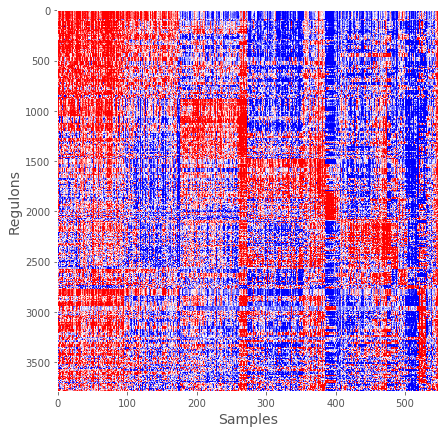

In [59]:
# Infer transcriptional programs
reference_df = eigengenes.copy()
programs, _ = miner.mosaic(dfr=reference_df,clusterList=centroidClusters,minClusterSize_x=int(np.ceil(0.01*expressionData.shape[1])),minClusterSize_y=5,allow_singletons=False,max_groups=50,saveFile=os.path.join(resultsDirectory,"regulon_activity_heatmap.pdf"),random_state=12)   
transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs,referenceDictionary)
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
programs_dictionary = {str(i):program_list[i] for i in range(len(program_list))}
miner.write_json(programs_dictionary,os.path.join(resultsDirectory,"output/transcriptional_programs.json"))
mosaicDf = reference_df.loc[np.hstack(program_list),np.hstack(states)]
mosaicDf.to_csv(os.path.join(resultsDirectory,"output/regulons_activity_heatmap.csv"))

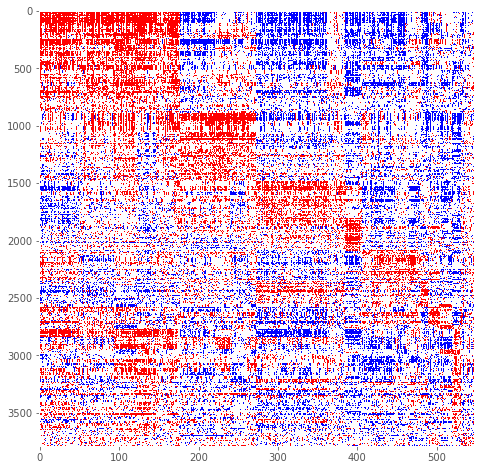

In [60]:
dfr = overExpressedMembersMatrix-underExpressedMembersMatrix
mtrx = dfr.loc[np.hstack(program_list),np.hstack(states)]
plt.figure(figsize=(8,8))
plt.imshow(mtrx,cmap="bwr",vmin=-1,vmax=1,aspect=float(mtrx.shape[1])/float(mtrx.shape[0]))
plt.grid(False)
plt.savefig(os.path.join(resultsDirectory,"output/mosaic_all.pdf"),bbox_inches="tight")

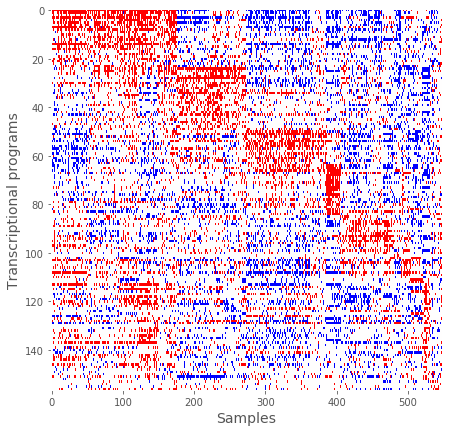

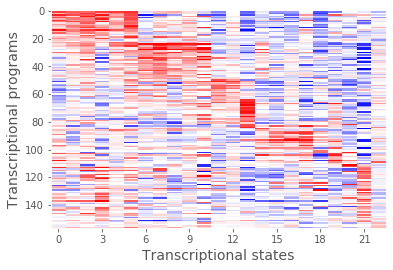

In [61]:
# Determine activity of transcriptional programs in each sample
statesDf = miner.reduceModules(df=dfr.loc[np.hstack(program_list),np.hstack(states)],programs=program_list,states=states,stateThreshold=0.50,saveFile=os.path.join(resultsDirectory,"output/transcriptional_programs.pdf"))

# Cluster patients into subtypes and give the activity of each program in each subtype
programsVsStates = miner.programsVsStates(statesDf,states,filename=os.path.join(resultsDirectory,"output/programs_vs_states.pdf"),showplot=True)